In [1]:
# Author: Anonymous
# project: Cat vs Dog


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm

from skimage import io, transform
from keras.utils import to_categorical
import time
from sklearn.model_selection import train_test_split
seed = 333
np.random.seed(seed)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['animals10', 'horses-or-humans-dataset']


In [2]:
#path to images
img_dir = "../input/animals10/animals/raw-img"
img_dir2 = "../input/horses-or-humans-dataset/horse-or-human/horse-or-human"

#list all available images type
print(os.listdir(img_dir))
print(os.listdir(img_dir2))

['cavallo', 'cane', 'farfalla', 'gallina', 'elefante', 'gatto', 'ragno', 'mucca', 'scoiattolo', 'pecora']
['train', 'validation']


In [3]:
def load_data(img_dir,img_dir2):
    X = []
    y = []
    labels = []
    idx = 0
    for i,folder_name in enumerate(os.listdir(img_dir)):
        if folder_name in ( "gatto","cane"):
            labels.append(folder_name)
            for file_name in tqdm(os.listdir(f'{img_dir}/{folder_name}')):
                if file_name.endswith('jpeg'):
                    im = cv2.imread(f'{img_dir}/{folder_name}/{file_name}')
                    if im is not None:
                        im = cv2.resize(im, (100, 100))
                        X.append(im)
                        y.append(idx)
        idx+=1
    idx = 2
    for i,folder_name in enumerate(os.listdir(img_dir2)):
        #here we get validation and train
        for j,folder_name1 in enumerate(os.listdir(os.path.join(img_dir2,folder_name))):
            if folder_name1 in ( "humans"):
                if folder_name1 not in labels:
                    labels.append(folder_name1)
                for file_name in tqdm(os.listdir(f'{img_dir2}/{folder_name}/{folder_name1}')):
                    if file_name.endswith('png'):
                        im = cv2.imread(f'{img_dir2}/{folder_name}/{folder_name1}/{file_name}')
                    if im is not None:
                        im = cv2.resize(im, (100, 100))
                        X.append(im)
                        y.append(idx)
    X = np.asarray(X)
    y = np.asarray(y)
    labels = np.asarray(labels)
    return X,y,labels

def load_data1(img_dir2):
    X = []
    y = []
    labels = []
    idx = 2
    for i,folder_name in enumerate(os.listdir(img_dir2)):
        #here we get validation and train
        for j,folder_name1 in enumerate(os.listdir(os.path.join(img_dir2,folder_name))):
            if folder_name1 in ( "humans"):
                if folder_name1 not in labels:
                    labels.append(folder_name)
                for file_name in tqdm(os.listdir(f'{img_dir2}/{folder_name}/{folder_name1}')):
                    if file_name.endswith('png'):
                        im = io.imread(f'{img_dir2}/{folder_name}/{folder_name1}/{file_name}')
                    if im is not None:
                        im = transform.resize(im, (100, 100))
                        X.append(im)
                        y.append(idx)
            
    
    X = np.asarray(X)
    y = np.asarray(y)
    labels = np.asarray(labels)
    return X,y,labels

In [4]:
X,y,labels = load_data(img_dir,img_dir2)
#X1,y1,labels1 = load_data1(img_dir2)
#X,y,labels = X2,y2,labels1+labels2

100%|██████████| 128/128 [00:00<00:00, 385.70it/s]


In [5]:
#fix y
y = y.reshape(-1,1)


In [6]:
for i,_ in enumerate(y):
    if y[i] == 1:
        y[i]=0
    elif y[i] == 2:
        pass
    else:
        y[i]=1


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [8]:
train_img = X_train
train_labels = y_train
test_img = X_test
test_labels = y_test
train_img.shape, train_labels.shape, test_img.shape, test_labels.shape

((5643, 100, 100, 3), (5643, 1), (1411, 100, 100, 3), (1411, 1))

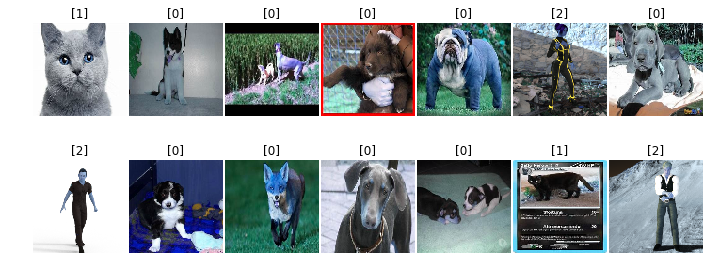

In [9]:
#show random samples
rand_14 = np.random.randint(0, train_img.shape[0],14)
sample_img = train_img[rand_14]
sample_labels = train_labels[rand_14]
num_rows, num_cols = 2, 7
f, ax = plt.subplots(num_rows, num_cols, figsize=(12,5),gridspec_kw={'wspace':0.03, 'hspace':0.01})
for r in range(num_rows):
    for c in range(num_cols):
        image_index = r * 7 + c
        ax[r,c].axis("off")
        ax[r,c].imshow(sample_img[image_index])
        ax[r,c].set_title('%s' % sample_labels[image_index])
plt.show()
plt.close()

In [10]:
#one-hot-encode the labels
num_classes = len(labels)
train_labels_cat = to_categorical(train_labels,num_classes)
test_labels_cat = to_categorical(test_labels,num_classes)
train_labels_cat.shape, test_labels_cat.shape

((5643, 3), (1411, 3))

In [11]:
# re-shape the images data
train_data = train_img
test_data = test_img
train_data.shape, test_data.shape

((5643, 100, 100, 3), (1411, 100, 100, 3))

In [12]:
# shuffle the training dataset & set aside val_perc % of rows as validation data
for _ in range(5): 
    indexes = np.random.permutation(len(train_data))

# randomly sorted!
train_data = train_data[indexes]
train_labels_cat = train_labels_cat[indexes]

# now we will set-aside val_perc% of the train_data/labels as cross-validation sets
val_perc = 0.10
val_count = int(val_perc * len(train_data))
print(val_count)

# first pick validation set
val_data = train_data[:val_count,:]
val_labels_cat = train_labels_cat[:val_count,:]

# leave rest in training set
train_data2 = train_data[val_count:,:]
train_labels_cat2 = train_labels_cat[val_count:,:]

train_data2.shape, train_labels_cat2.shape, val_data.shape, val_labels_cat.shape, test_data.shape, test_labels_cat.shape

564


((5079, 100, 100, 3),
 (5079, 3),
 (564, 100, 100, 3),
 (564, 3),
 (1411, 100, 100, 3),
 (1411, 3))

In [13]:
# a utility function that plots the losses and accuracies for training & validation sets across our epochs
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['acc'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['acc']
    val_acc_vals = history['val_acc']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

In [14]:
def print_time_taken(start_time, end_time):
    secs_elapsed = end_time - start_time
    
    SECS_PER_MIN = 60
    SECS_PER_HR  = 60 * SECS_PER_MIN
    
    hrs_elapsed, secs_elapsed = divmod(secs_elapsed, SECS_PER_HR)
    mins_elapsed, secs_elapsed = divmod(secs_elapsed, SECS_PER_MIN)
    
    if hrs_elapsed > 0:
        print('Time taken: %d hrs %d mins %d secs' % (hrs_elapsed, mins_elapsed, secs_elapsed))
    elif mins_elapsed > 0:
        print('Time taken: %d mins %d secs' % (mins_elapsed, secs_elapsed))
    elif secs_elapsed > 1:
        print('Time taken: %d secs' % (secs_elapsed))
    else:
        print('Time taken - less than 1 sec')

In [15]:
def get_commonname(idx):
    sciname = labels[idx][0]
    return {
        'cane':'dog',
        'gatto':'cat',
        'humans':'human'
    }[sciname]
    

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


import numpy as np
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,Activation,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.datasets import mnist
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from PIL import Image

In [17]:
#data augmentation
datagen = ImageDataGenerator(
        rotation_range=30,
        zoom_range = 0.25,  
        width_shift_range=0.1, 
        height_shift_range=0.1)
# datagen = ImageDataGenerator(
#     rotation_range=8,
#     shear_range=0.3,
#     zoom_range = 0.08,
#     width_shift_range=0.08,
#     height_shift_range=0.08)

In [18]:
#create multiple cnn model for ensembling
#model 1
model = Sequential()

model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (100, 100, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))


model.add(Conv2D(256, kernel_size = 4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

# use adam optimizer and categorical cross entropy cost
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
# after each epoch decrease learning rate by 0.95
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# train
epochs = 50
j=0
start_time = time.time()
history = model.fit_generator(datagen.flow(train_data2, train_labels_cat2, batch_size=64),epochs = epochs, steps_per_epoch = train_data2.shape[0]/64,validation_data = (val_data, val_labels_cat), callbacks=[annealer], verbose=1)
end_time = time.time()
print_time_taken(start_time, end_time)


print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(j+1,epochs,history.history['acc'][epochs-1],history.history['val_acc'][epochs-1]))

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
80/79 [==============================] - 15s 192ms/step - loss: 1.2778 - acc: 0.6118 - val_loss: 3.7131 - val_acc: 0.5177
Epoch 2/50
80/79 [==============================] - 11s 139ms/step - loss: 1.0319 - acc: 0.6655 - val_loss: 1.9878 - val_acc: 0.5975
Epoch 3/50
80/79 [==============================] - 12s 144ms/step - loss: 0.8768 - acc: 0.6881 - val_loss: 0.9400 - val_acc: 0.7677
Epoch 4/50
80/79 [==============================] - 11s 144ms/step - loss: 0.7925 - acc: 0.7020 - val_loss: 0.9790 - val_acc: 0.7270
Epoch 5/50
80/79 [==============================] - 11s 142ms/step - loss: 0.8668 - acc: 0.7028 - val_loss: 0.9227 - val_acc: 0.6791
Epoch 6/50
80/79 [==============================] - 11s 141ms/step - loss: 0.7217 - acc: 0.7221 - val_loss: 0.7847 - val_acc: 0.7376
Epoch 7/50
80/79 [==============================] - 11s 142ms/step - loss: 0.6862 - acc: 0.7323 - val_loss: 0.6433 - val_acc: 0.7323
Epoch 8/50
80/79 [===

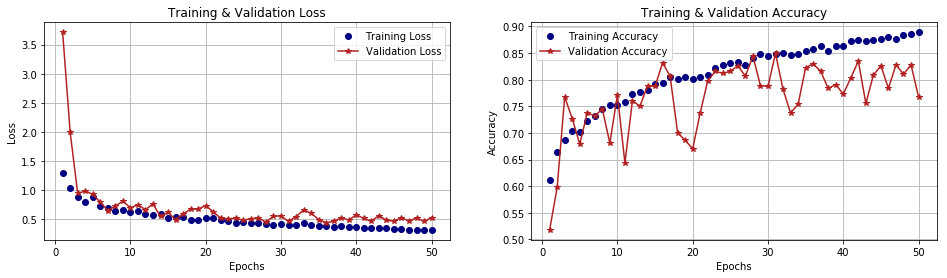

In [20]:
show_plots(history.history)

In [21]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels_cat, batch_size=64)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

1411/1411 [==============================] - 0s 324us/step
Test loss: 0.4397 accuracy: 0.8044


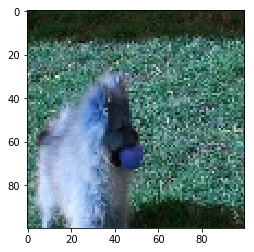

actual: dog
predicted: dog


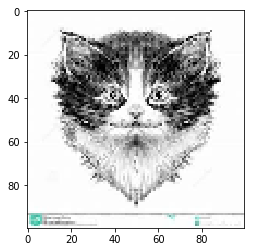

actual: cat
predicted: dog


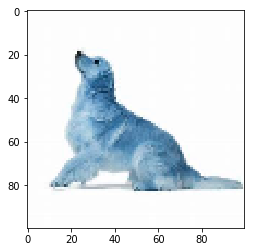

actual: dog
predicted: dog


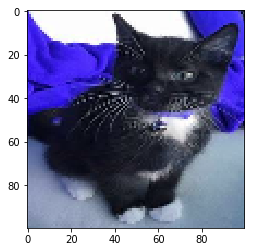

actual: cat
predicted: cat


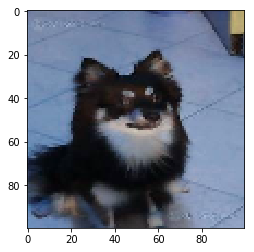

actual: dog
predicted: dog


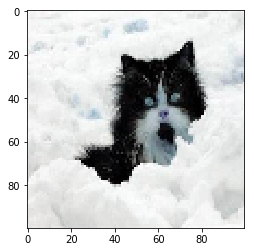

actual: cat
predicted: cat


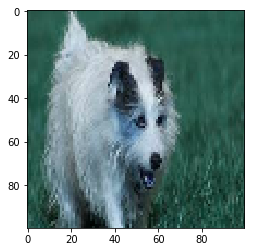

actual: dog
predicted: dog


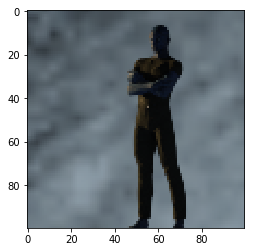

actual: human
predicted: human


In [22]:
im_list = [100,250,989,505,600,312,832,1400]
for i in im_list:
#     i = 1000  #index from test data to be used, change this other value to see a different image
    img = test_data[i]
    plt.imshow(img)
    plt.show()
    pred = model.predict_classes(img.reshape(-1,100,100,3))
    actual =  test_labels[i]
    print(f'actual: {get_commonname(actual)}')
    print(f'predicted: {get_commonname(pred)}')


In [23]:
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open("model_3.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model_3.h5")